In [1]:
!python --version

Python 3.8.6


### TODO

* ~Try a built-in optimizer (like grad descent w/ momentum) instead of constant learning rate. See how convergence time changes~
* ~Plot loss~
* ~Refactor (processors are modules)~
* ~Define `init_params` methods for each processor, initializing to params that have no effect on the signal (no-op  prior)~
  - this is something to note in writeup. talk about small changes to params having big effect in processors with feedback. And how starting from no effect initially is good for live performance settings.
* ~Add a simple clipping nonlinearity effect to see how `grad` does with that~
* ~Refactoring~
  - ~Use dicts for labeled params instead of n-d arrays (jax handles this)~
  - ~Move parameter label creation into processor fns~
* Estimate params for multiple serially-connected filters (create a general `serial_processors` processor)
* Animate changes in output signal over time, compared with target
* Run on GPU & measure performance differences
* Performance viability of realistic-length signals
* Apply to audio to hear perceptual differences
* More than one training pair (more than just impulse response)
* Use a perceptual loss function instead of mse (steal DDSP's multi-scale spectral loss fn)
* Improve performance
  - Speed things up with [JIT](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#Using-jit-to-speed-up-functions)
  - I don't think functions truly need to be pure. I tried passing in a plain np array and changing it in place and it seemed to work fine. Maybe we can use shared buffers to improve memory usage?
* End-goal (ready for blog post): Implement freeverb and perform dereverbing

In [2]:
import jax.numpy as jnp
from jax import grad, value_and_grad, jit, vmap
from jax import random
from jax.experimental import optimizers
from scipy import signal
import numpy as np

In [3]:
import sys
sys.path.append('./')
sys.path.append('./processors') # TODO define __init__.py and `from processors import fir_filter, iir_filter
import fir_filter, iir_filter, clip, serial_processors

In [4]:
from plotters import plot_filter, plot_loss, plot_params

In [5]:
def mse(X, Y):
    return ((Y - X) ** 2).mean()

In [6]:
def mae(X, Y):
    return jnp.abs(Y - X).mean()

In [7]:
def process(params, processor, X, Y):
    state = processor.init_state_from_params(params)
    for i, x in enumerate(X):
        y, state = processor.tick(x, params, state)
        Y = Y.at[i].set(y) # Y[i] = y
    return Y

In [8]:
def processor_loss(params, processor, X, Y, Y_target):
    Y = process(params, processor, X, Y)
    return mse(Y, Y_target)

In [9]:
def train(processor, X, step_size=0.1, num_batches=10):
    params_target = processor.create_params_target()
    init_params = processor.init_params()
    params_history = {key: [param] for (key, param) in init_params.items()}
    loss_history = np.zeros(num_batches)
    Y = jnp.zeros(X.size)
    Y_target = process(params_target, processor, X, Y)

    opt_init, opt_update, get_params = optimizers.adam(step_size)
    opt_state = opt_init(init_params)
    for batch_i in range(num_batches):
        loss, gradient = value_and_grad(processor_loss)(get_params(opt_state), processor, X, Y, Y_target)
        opt_state = opt_update(batch_i, gradient, opt_state)
        loss_history[batch_i] = loss
        new_params = get_params(opt_state)
        for param_key in new_params.keys():
            params_history[param_key].append(new_params[param_key])

    params_estimated = get_params(opt_state)
    Y_estimated = process(params_estimated, processor, X, Y)
    return params_estimated, params_target, Y_estimated, Y_target, params_history, loss_history

In [10]:
def process_serial(params, processor, processors, X, Y):
    state = processor.init_state_from_params(processors, params)
    for i, x in enumerate(X):
        y, state = processor.tick(processors, x, params, state)
        Y = Y.at[i].set(y) # Y[i] = y
    return Y

In [11]:
def processor_loss_serial(params, processor, processors, X, Y, Y_target):
    Y = process_serial(params, processor, processors, X, Y)
    return mse(Y, Y_target)

In [12]:
def train_serial(processors, X, step_size=0.1, num_batches=10):
    processor = serial_processors
    params_target = processor.create_params_target(processors)
    init_params = processor.init_params(processors)
    params_history = {processor_key: {key: [param] for (key, param) in inner_init_params.items()} for (processor_key, inner_init_params) in init_params.items()}
    loss_history = np.zeros(num_batches)
    Y = jnp.zeros(X.size)
    Y_target = process_serial(params_target, processor, processors, X, Y)

    opt_init, opt_update, get_params = optimizers.adam(step_size)
    opt_state = opt_init(init_params)
    for batch_i in range(num_batches):
        loss, gradient = value_and_grad(processor_loss_serial)(get_params(opt_state), processor, processors, X, Y, Y_target)
        opt_state = opt_update(batch_i, gradient, opt_state)
        loss_history[batch_i] = loss
        new_params = get_params(opt_state)
        for (processor_key, processor_params) in new_params.items():
            for (param_key, param) in processor_params.items():
                params_history[processor_key][param_key].append(param)

    params_estimated = get_params(opt_state)
    Y_estimated = process_serial(params_estimated, processor, processors, X, Y)
    return params_estimated, params_target, Y_estimated, Y_target, params_history, loss_history

In [13]:
%%time
X = jnp.concatenate([jnp.array([1.0]), jnp.zeros(13)])
params_estimated, params_target, Y_estimated, Y_target, params_history, loss_history = train(fir_filter, X)

CPU times: user 1.67 s, sys: 188 ms, total: 1.86 s
Wall time: 1.61 s


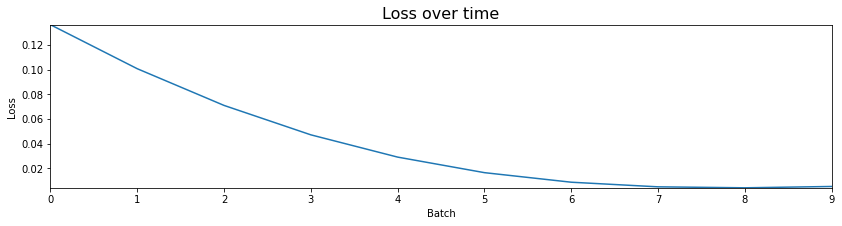

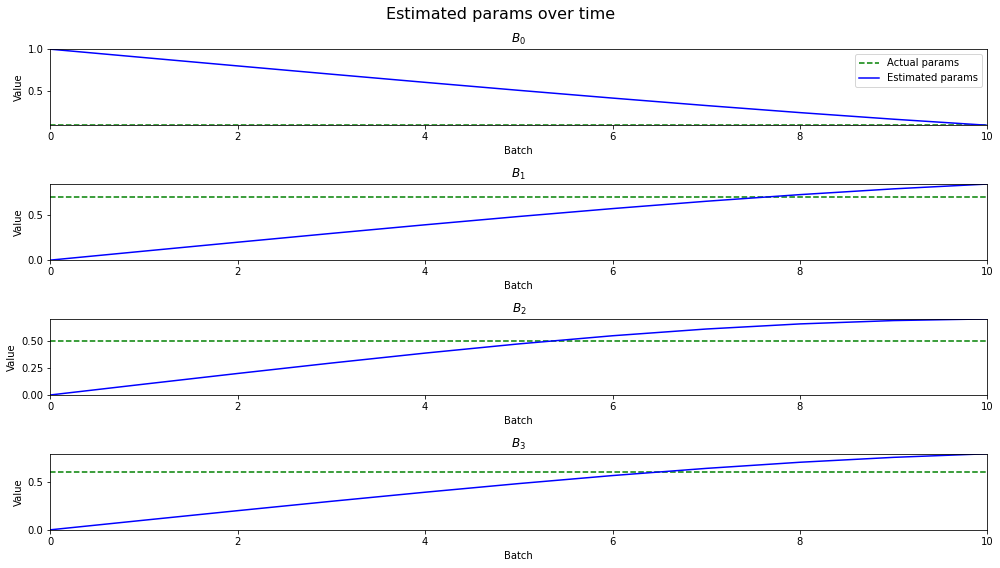

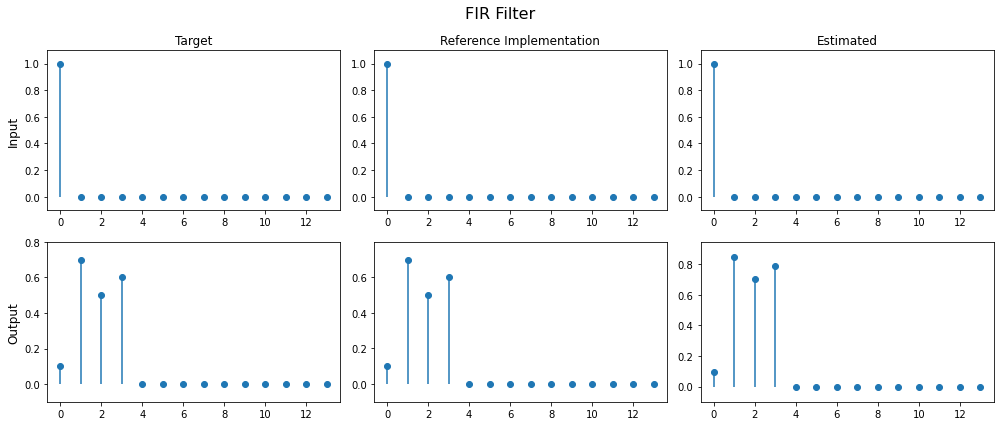

In [14]:
plot_loss(loss_history)
plot_params(params_target, params_history)
Y_reference = signal.lfilter(params_target['B'], [1.0], X)
plot_filter(X, Y_target, Y_reference, Y_estimated, 'FIR Filter')

In [15]:
%%time
params_estimated, params_target, Y_estimated, Y_target, params_history, loss_history = train(iir_filter, X)

CPU times: user 3.56 s, sys: 400 ms, total: 3.96 s
Wall time: 3.39 s


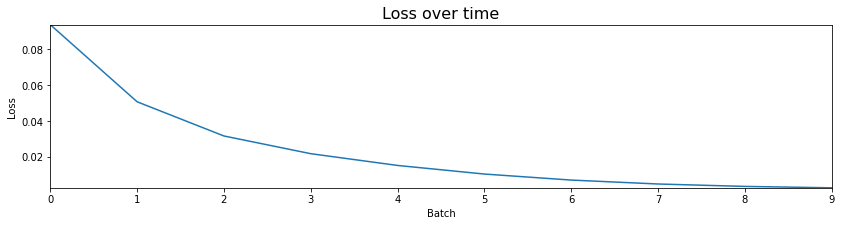

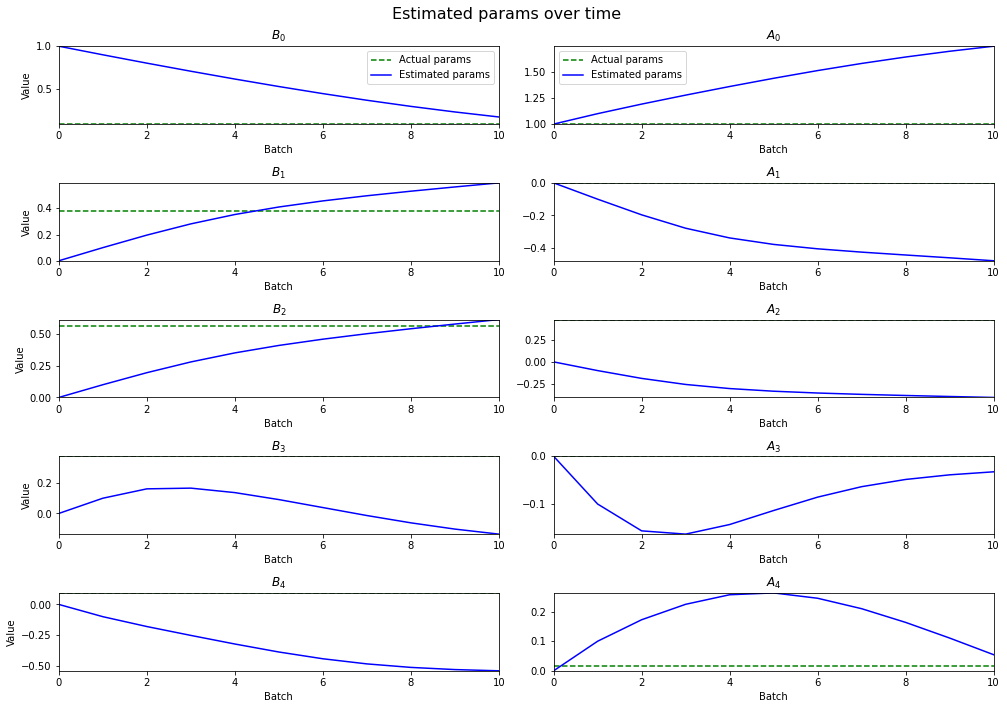

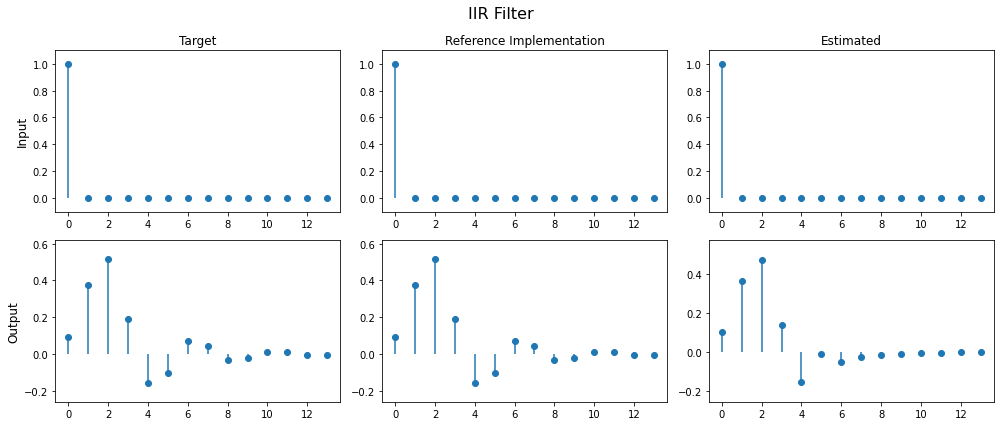

In [16]:
plot_loss(loss_history)
plot_params(params_target, params_history)
Y_reference = signal.lfilter(params_target['B'], params_target['A'], X)
plot_filter(X, Y_target, Y_reference, Y_estimated, 'IIR Filter')

In [17]:
%%time
X = np.random.uniform(-2, 2, X.size)
params_estimated, params_target, Y_estimated, Y_target, params_history, loss_history = train(clip, X)

CPU times: user 1.98 s, sys: 266 ms, total: 2.24 s
Wall time: 1.85 s


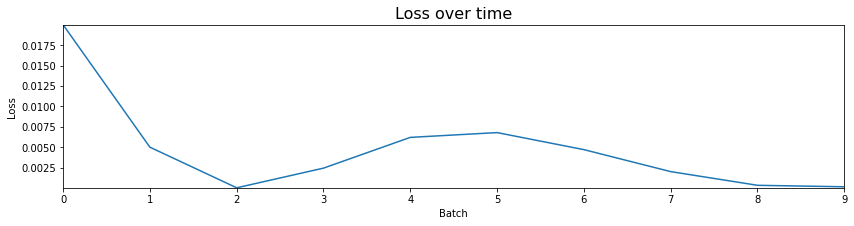

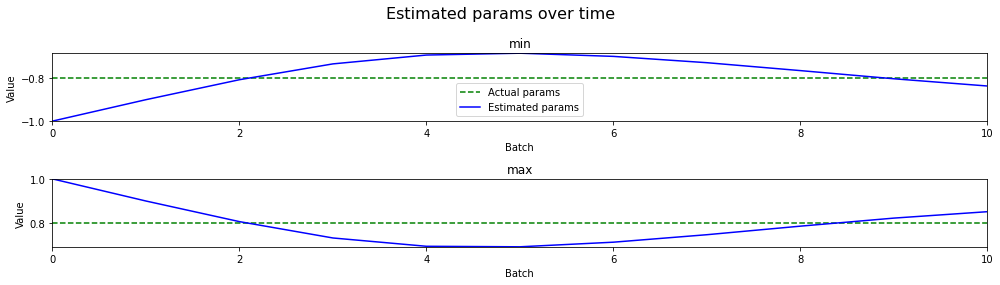

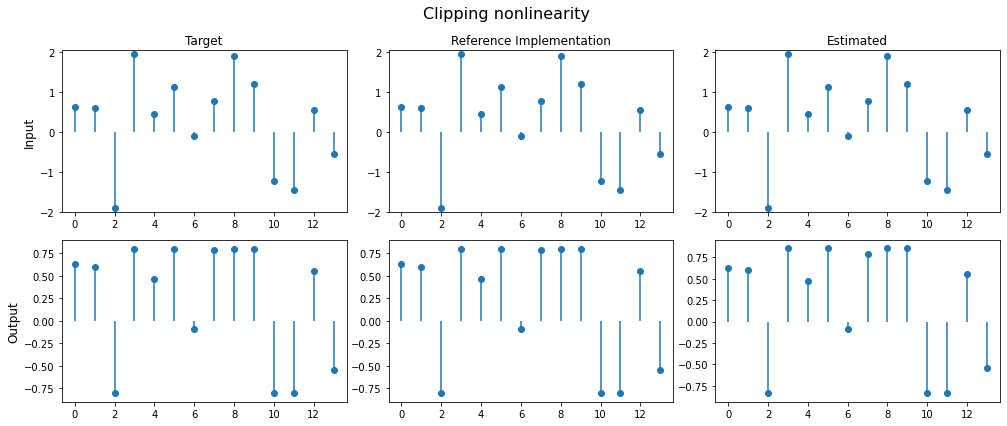

In [18]:
plot_loss(loss_history)
plot_params(params_target, params_history)
Y_reference = np.clip(X, params_target['min'], params_target['max'])
plot_filter(X, Y_target, Y_reference, Y_estimated, 'Clipping nonlinearity')

In [19]:
%%time
X = np.random.uniform(-2, 2, X.size)
params_estimated, params_target, Y_estimated, Y_target, params_history, loss_history = train_serial([iir_filter, clip], X, num_batches=50)

CPU times: user 21.4 s, sys: 2.62 s, total: 24 s
Wall time: 20.2 s


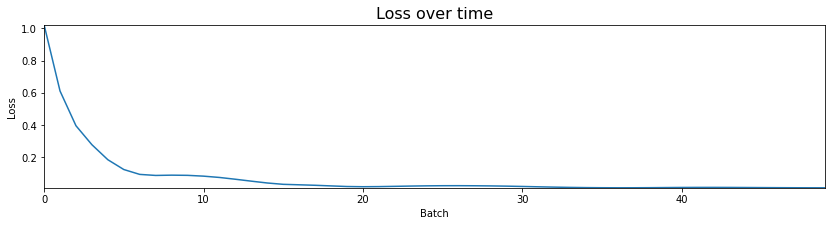

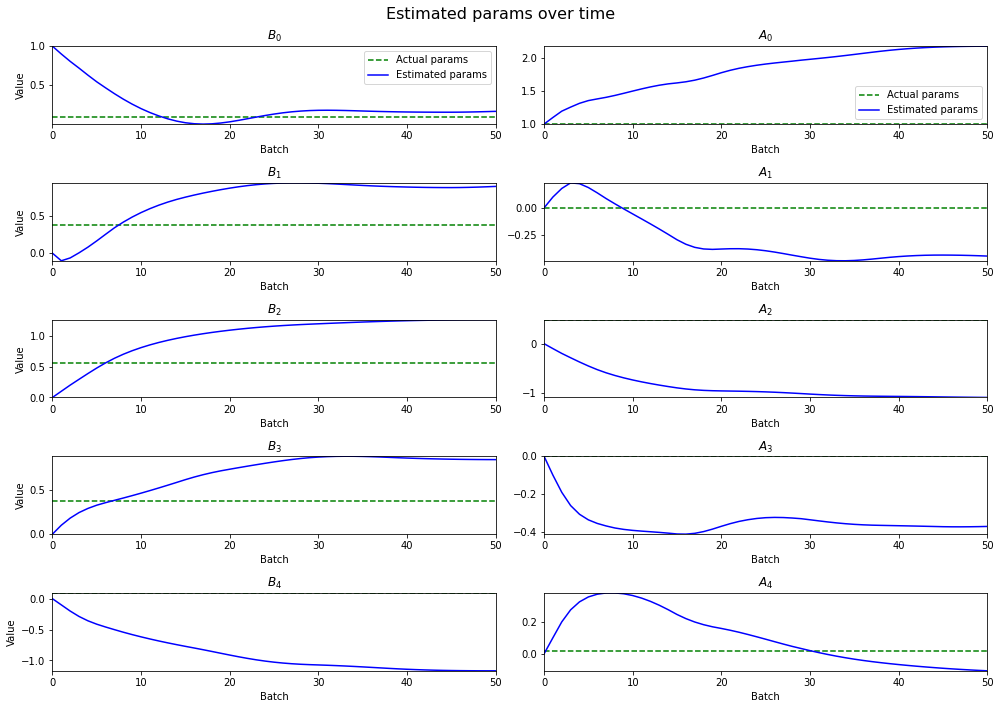

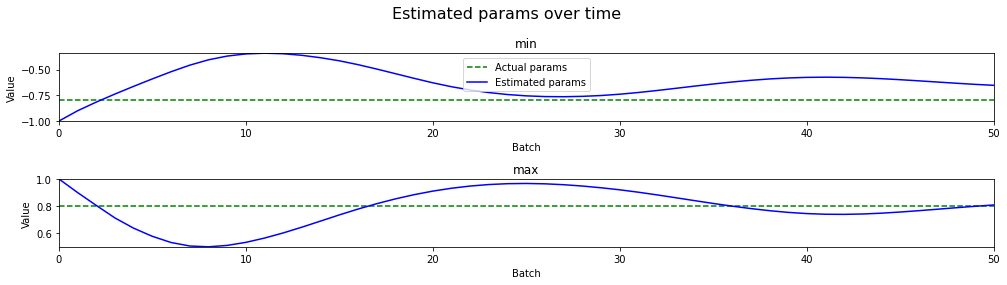

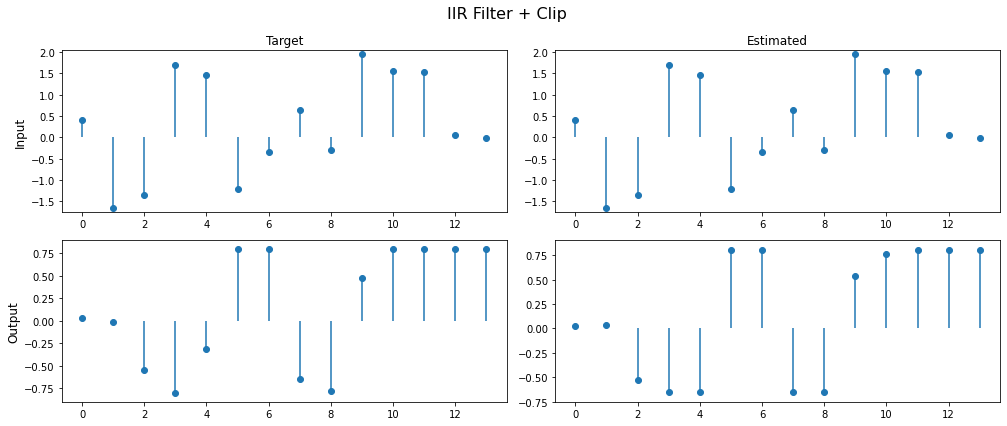

In [20]:
plot_loss(loss_history)
plot_params(params_target['iir_filter'], params_history['iir_filter'])
plot_params(params_target['clip'], params_history['clip'])

plot_filter(X, Y_target, None, Y_estimated, 'IIR Filter + Clip')

In [21]:
# import IPython
# from scipy.io.wavfile import read as wavread

# wav_fs, audio = wavread('speech-male.wav')
# audio = audio.astype(float) / audio.max()
# print('Original audio:')
# IPython.display.Audio(audio, rate=wav_fs)